#Brain Segmentation
This notebook install 3D Slicer and run script that use SkullStripper extension for create a 3D label for brain MRI volume

In [1]:
!sudo apt-get update
!sudo apt-get install libglu1-mesa libpulse-mainloop-glib0 libnss3 libasound2 qt5dxcb-plugin libxrender1 libxtst6 libxi6
!sudo apt install xvfb
!apt install jq

Hit:1 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:2 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:3 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Get:4 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:5 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Get:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Ign:7 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Get:8 https://r2u.stat.illinois.edu/ubuntu jammy Release [5,713 B]
Get:9 https://r2u.stat.illinois.edu/ubuntu jammy Release.gpg [793 B]
Hit:10 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:11 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:12 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:13 http://archive.ubuntu.com/ubuntu jammy-updates/universe amd64 Packages [1,451 kB]
Get:14 http://a

In [2]:
# Download slicer installer script
!wget -q --show-progress https://github.com/Slicer/SlicerDocker/raw/refs/heads/main/scripts/slicer-download.sh

slicer-download.sh  100%[===================>]   2.91K  --.-KB/s    in 0s      


In [3]:
# install slicer with the SkullStripper extension
!sudo bash ./slicer-download.sh -s -v 5.6.2 -d /content/Slicer-5.6.2 -e "SkullStripper"

Installing to /content/Slicer-5.6.2 (version 5.6.2): Slicer SkullStripper
######################################################################## 100.0%
######################################################################## 100.0%
Installing to /content/Slicer-5.6.2
/content/Slicer-5.6.2


In [4]:
# Download example MRI head file
!wget -q https://github.com/MoriahDavid/Synthetic-3D-Tumors/raw/refs/heads/main/data/MRHead.nrrd

In [5]:
import os

input_file_path = '/content/MRHead.nrrd'
output_file_path = os.path.join(os.path.dirname(input_file_path), os.path.basename(input_file_path).replace('.nrrd', "-label.nrrd"))


In [6]:
code = """
import sys
import os
import slicer
input_path = sys.argv[1]
output_path = sys.argv[2]

# Load the input MRI volume
input_volume = slicer.util.loadVolume(input_path)

# Create an output node for the brain surface and brain mask
brain_surface = slicer.mrmlScene.AddNewNodeByClass('vtkMRMLModelNode')
brain_mask = slicer.mrmlScene.AddNewNodeByClass('vtkMRMLSegmentationNode')

# Get the SkullStripper module logic
stripper_logic = slicer.modules.skullstripper.logic()

# Define the parameters as per the XML configuration
parameters = {
    'inputVolume': input_volume.GetID(),
    'brainSurface': brain_surface.GetID(),
    'brainMask': brain_mask.GetID(),
    'nIterations': 100,  # default value in the config
    'sphericalResolution': 12,  # default value in the config
    'postDilationRadius': 0,  # default value in the config
}

# Apply the SkullStripper
slicer.cli.run(slicer.modules.skullstripper, None, parameters, wait_for_completion=True)

# Save the label
labelmapVolumeNode = slicer.mrmlScene.AddNewNodeByClass("vtkMRMLLabelMapVolumeNode")
slicer.modules.segmentations.logic().ExportVisibleSegmentsToLabelmapNode(brain_mask, labelmapVolumeNode, input_volume)
slicer.util.saveNode(labelmapVolumeNode, output_path)

exit()
"""

import os
with open('/content/brain-mask.py', 'w') as f:
    f.write(code)

In [7]:
!xvfb-run -a /content/Slicer-5.6.2/Slicer --no-splash --no-main-window --python-script /content/brain-mask.py $input_file_path $output_file_path

QStandardPaths: XDG_RUNTIME_DIR not set, defaulting to '/tmp/runtime-root'
qSlicerMarkupsModulePrivate::addToolBar: no main window is available, toolbar is not added
qSlicerSequencesModulePrivate::addToolBar: no main window is available, toolbar is not added
"Volume" Reader has successfully read the file "/content/MRHead.nrrd" "[0.30s]"
Found CommandLine Module, target is /content/Slicer-5.6.2/bin/../lib/Slicer-5.6/cli-modules/SkullStripper


ModuleType: CommandLineModule


SkullStripper command line: 

/content/Slicer-5.6.2/bin/../lib/Slicer-5.6/cli-modules/SkullStripper --iteration 100 --division 12 --dilation 0 /tmp/Slicer-/CIFF_vtkMRMLScalarVolumeNodeB.nrrd /tmp/Slicer-/CIFF_vtkMRMLModelNodeB.vtp /tmp/Slicer-/CIFF_vtkMRMLSegmentationNodeB.nrrd 


SkullStripper standard output:

Input image orientation: 0 0 -1
1 0 0
0 -1 0

[0, 0, 0]  [0, 0, 0]  [86.6449, -133.929, 116.786]
[1, 0, 0]  [256, 0, 0]  [86.6449, 122.071, 116.786]
[0, 1, 0]  [0, 256, 0]  [86.6449, -133.929, -139.214]
[1, 

# Show result

In [8]:
!pip -q install pynrrd

In [9]:
import nrrd
from matplotlib import pyplot as plt
%matplotlib inline
import numpy as np

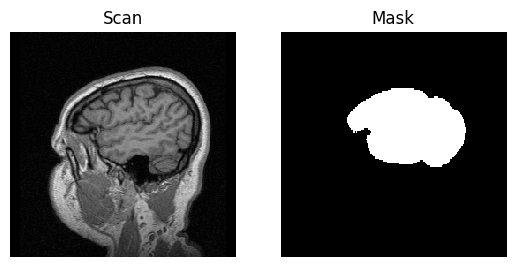

In [10]:
volume, header = nrrd.read(output_file_path)
volume2, header = nrrd.read(input_file_path)

slice_index = 27

f = plt.figure()
f.add_subplot(1,2, 1)
plt.imshow(volume2[:,  :, slice_index].transpose(), interpolation='nearest', cmap='gray')
plt.axis('off')
plt.title("Scan")
f.add_subplot(1,2, 2)
plt.imshow(volume[:, :, slice_index].transpose(), interpolation='nearest', cmap='gray')
plt.axis('off')
plt.title("Mask")
plt.show(block=True)